In [65]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import time
import pandas_profiling
import missingno as msno
import collections

import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve, LeaveOneOut, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score,recall_score, precision_score,f1_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegressionCV
#from sklearn.feature_selection import RFECV
from imblearn.over_sampling import BorderlineSMOTE,SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from scipy.stats import chi2_contingency
#from xgboost import XGBClassifier

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [66]:
def checking_missing (cx, columns_to_check):
    
    row_with_missing_cx = [row_idx for row_idx, row in cx[columns_to_check].isnull().iterrows() if True in row.values]
    print("\nMissing Value Summary\n{}".format("-"*35))
    print(cx.isnull().sum(axis = 0))
       
    return 


def chi2_check(df, categorical_cols, target_col, p_value = 0.05):
    chi2_check = []
    for c in categorical_cols:
        temp = pd.crosstab(df[c], pt_profile_cleaned[target_col])
        print(temp)
        chi_res = chi2_contingency(temp)
        print('Chi2 Statistic for column "{}": {}, p-value: {}\n{}'.format(c, chi_res[0], chi_res[1], "-"*60))
    
        if  chi_res[1] < p_value:
            chi2_check.append('Reject Null Hypothesis')
        else:
            chi2_check.append('Fail to Reject Null Hypothesis')
    
        results_df = pd.DataFrame(data = [categorical_cols, chi2_check]).T 
        results_df.columns = ['Column', 'Hypothesis']
    return results_df


def confusion_matrix_1(pred,test):
    confusion = collections.defaultdict(int)
    for i in range(len(pred)):
        if (pred[i] == 1) and (test.values[i] == 1):
            confusion["TP"] += 1
        elif (pred[i] == 1) and (test.values[i] == 0):
            confusion["FP"] += 1
        elif (pred[i] == 0) and (test.values[i] == 0):
            confusion["TN"] += 1
        elif (pred[i] == 0) and (test.values[i] == 1):
            confusion["FN"] += 1
    print(classification_report(test,pred))
    return pd.DataFrame({"actual_positive": [confusion['TP'],confusion['FN']],"actual_negative":[confusion['FP'],confusion['TN']]}, index = ['predict_positive','predict_negative'])

# 1. Loading Data, EDA and Data Preprocessing 
## 1.1. Patient profile table

In [3]:
pt_df = pd.read_json('patient_profiles.json', orient='records')
pt_df.shape
pt_df.head()

prof_list= pt_df['patient_profiles'].tolist()
#len(prof_list)

unioned_df = pd.DataFrame()
for w in pt_df.index:
    df0 = unioned_df
    df1=pd.json_normalize(prof_list[w])
    df1['institution'] = pt_df.iloc[w, 0]
    df1['cohort_id'] = pt_df.iloc[w, 1]
    unioned_df = pd.concat([df0, df1])
unioned_df.shape
unioned_df.head()

(7, 3)

,institution,cohort_id,patient_profiles
0,Saint Penelope Medical Center,14562556998,"[{'patient_id': '102bb8fae', 'demographics': {..."
1,"BioLab, Inc.",14562556998,"[{'patient_id': '100688fb9', 'demographics': {..."
2,University Hospital System,14562556998,"[{'patient_id': '1002df1d3', 'demographics': {..."
3,Goodfellow Research Institute,14562556998,"[{'patient_id': '104fc5e3c', 'demographics': {..."
4,Montague Hospital,14562556998,"[{'patient_id': '1010441f', 'demographics': {'..."


(2351, 15)

,patient_id,demographics.gender,demographics.age,status.disease_sub_type,status.comorbidity_index,status.cohort_qualifier,status.smoking_status,status.months_since_diagnosis,demographics.race,institution,cohort_id,status.days_since_diagnosis,status.alcohol_usage,status.exercise_frequency,status.bmi_level
0,102bb8fae,Female,68.0,A,0.0,True,never,1.0,NaN,Saint Penelope Medical Center,14562556998,NaN,NaN,NaN,NaN
1,10e32947f,Female,66.0,A,NaN,True,former,0.0,White,Saint Penelope Medical Center,14562556998,NaN,NaN,NaN,NaN
2,11156e14a,Male,61.0,A,1.0,True,never,16.0,White,Saint Penelope Medical Center,14562556998,NaN,NaN,NaN,NaN
3,113d8066d,Male,62.0,B,NaN,True,current,0.0,NaN,Saint Penelope Medical Center,14562556998,NaN,NaN,NaN,NaN
4,113ec3f1,Male,59.0,A,NaN,True,former,9.0,NaN,Saint Penelope Medical Center,14562556998,NaN,NaN,NaN,NaN


## 1.2. Targets table

In [4]:
target = pd.read_csv('targets.csv')
target.shape
target.head()

print(len(target['patient_id'].unique()), len(unioned_df['patient_id'].unique()))

(1734, 3)

,patient_id,biomarker_id,target_label
0,1002df1d3,89c43bb4,0
1,1010441f,3ae31327,0
2,101eb6af1,1d8f7bab9,0
3,10204394e,129ee8c6c,0
4,1021d329b,1b44145bd,0


1734 2351


### # of patient in target_label is 1734, # of patient in patient profile is 2351. So target table is left joined with patient profile

In [5]:
pt_profile = pd.merge(target, unioned_df, how = 'left', on = 'patient_id' )
pt_profile.head(1)
pt_profile.shape

,patient_id,biomarker_id,target_label,demographics.gender,demographics.age,status.disease_sub_type,status.comorbidity_index,status.cohort_qualifier,status.smoking_status,status.months_since_diagnosis,demographics.race,institution,cohort_id,status.days_since_diagnosis,status.alcohol_usage,status.exercise_frequency,status.bmi_level
0,1002df1d3,89c43bb4,0,Male,46.0,A,NaN,True,former,20.0,Asian,University Hospital System,14562556998,NaN,NaN,NaN,NaN


(1734, 17)

## 1.3. Data profiling for patient profile

In [6]:
pt_profile_report = pandas_profiling.ProfileReport(pt_profile)
pt_profile_report#.to_file("pt_profile.html")

Summarize dataset:   0%|          | 0/30 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Summary of observations from profiling
- Mixture of upper and lower case string values in: 
    - gender, 
    - smoking_status 
    - race
- Missing values in 
    - age, 
    - race, 
    - comorbidity_index, 
    - smoking_status, 
    - months_since_diagnosis, 
    - days_since_diagnosis, 
    - alcohol_usage, 
    - exercise_frequency, 
    - alcohol_usage, 
    - bmi_level
* High correlation between some variables, such as gender with smoking, race, and institution, institution with bmi, exercise, alcohol_usage

## 1.4. Preprocessing patient profile 
* Normalized upper and lowercase string values
* Dealing with missing values by filling categorical variables with "unknown" and continuous variables with median value

In [7]:
pt_profile['demographics.gender'].unique()
pt_profile['gender']=pt_profile['demographics.gender'].apply(lambda x: x.strip().lower())#.apply(lambda x: 1 if x.strip().lower() == 'male' else 0)
pt_profile['gender'].unique()
pt_profile['demographics.gender'].unique()
pt_profile[['gender', 'demographics.gender']][:5]

array(['Male', 'MALE', 'Female', 'FEMALE'], dtype=object)

array(['male', 'female'], dtype=object)

array(['Male', 'MALE', 'Female', 'FEMALE'], dtype=object)

,gender,demographics.gender
0,male,Male
1,male,MALE
2,female,Female
3,male,Male
4,male,Male


In [8]:
pt_profile['demographics.race'].unique()
pt_profile['race']=pt_profile['demographics.race'].fillna('missing').apply(lambda x: x.strip().lower())
pt_profile['race'].unique()
pt_profile[['race', 'demographics.race']][:5]

array(['Asian', 'BLACK OR AFRICAN AMERICAN', nan, 'White',
       'Black or African American', 'WHITE',
       'Native Hawaiian or Other Pacific Islander', 'ASIAN',
       'American Indian or Alaska Native',
       'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER',
       'AMERICAN INDIAN OR ALASKA NATIVE'], dtype=object)

array(['asian', 'black or african american', 'missing', 'white',
       'native hawaiian or other pacific islander',
       'american indian or alaska native'], dtype=object)

,race,demographics.race
0,asian,Asian
1,black or african american,BLACK OR AFRICAN AMERICAN
2,missing,NaN
3,white,White
4,asian,Asian


In [9]:
pt_profile['status.smoking_status'].unique()
pt_profile['smoking']=pt_profile['status.smoking_status'].fillna('unknown').apply(lambda x: x.strip().lower())
pt_profile['smoking'].unique()
pt_profile[['smoking', 'status.smoking_status']][:5]

array(['former', 'NEVER', 'never', 'current', nan, 'CURRENT', 'unknown',
       'FORMER', 'UNKNOWN'], dtype=object)

array(['former', 'never', 'current', 'unknown'], dtype=object)

,smoking,status.smoking_status
0,former,former
1,never,NEVER
2,never,never
3,never,never
4,former,former


In [10]:
pt_profile['demographics.age'].describe()
pt_profile['age']=pt_profile.loc[:, 'demographics.age'].fillna(pt_profile['demographics.age'].median())
pt_profile['age'].describe()
pt_profile[['age', 'demographics.age']][:5]

checking_missing(pt_profile[['age', 'demographics.age']], pt_profile[['age', 'demographics.age']].columns)

count    1611.000000
mean       59.790813
std         9.516331
min        25.000000
25%        54.000000
50%        61.000000
75%        67.000000
max        83.000000
Name: demographics.age, dtype: float64

count    1734.000000
mean       59.876586
std         9.177659
min        25.000000
25%        55.000000
50%        61.000000
75%        66.000000
max        83.000000
Name: age, dtype: float64

,age,demographics.age
0,46.0,46.0
1,52.0,52.0
2,55.0,55.0
3,69.0,69.0
4,52.0,52.0



Missing Value Summary
-----------------------------------
age                   0
demographics.age    123
dtype: int64


In [11]:
pt_profile['status.comorbidity_index'].unique()
pt_profile['comorbidity']=pt_profile['status.comorbidity_index'].astype('string').fillna('unknown').apply(lambda x: x.strip().lower())
pt_profile['comorbidity'].unique()
pt_profile[['comorbidity', 'status.comorbidity_index']][:5]

array([nan,  1.,  0.,  2.])

array(['unknown', '1.0', '0.0', '2.0'], dtype=object)

,comorbidity,status.comorbidity_index
0,unknown,NaN
1,unknown,NaN
2,unknown,NaN
3,unknown,NaN
4,unknown,NaN



Missing Value Summary
-----------------------------------
status.months_since_diagnosis     123
status.days_since_diagnosis      1611
dtype: int64


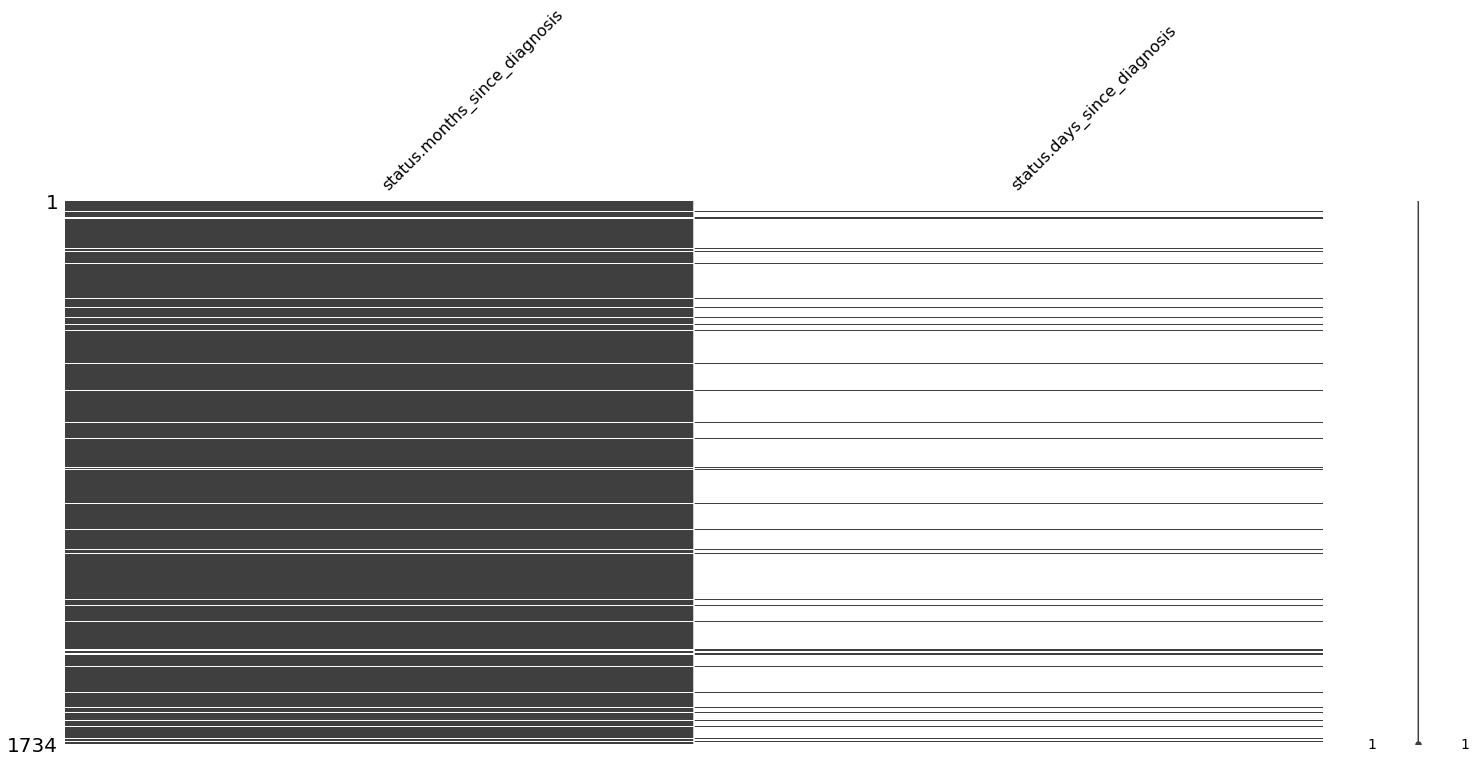

In [12]:
df_days = pt_profile[['status.months_since_diagnosis', 'status.days_since_diagnosis']]
checking_missing(df_days, df_days.columns)
mbar=msno.matrix(df_days)

#### Missing values in days_since_diagnosis and months_since_diagnosis are interwinded. So we create a new column by combining them together. 

,days_after_dx,status.months_since_diagnosis,status.days_since_diagnosis
0,600.0,20.0,NaN
1,0.0,0.0,NaN
2,0.0,0.0,NaN
3,270.0,9.0,NaN
4,300.0,10.0,NaN
5,0.0,0.0,NaN
6,0.0,0.0,NaN
7,510.0,17.0,NaN
8,150.0,5.0,NaN
9,0.0,NaN,0.0



Missing Value Summary
-----------------------------------
days_after_dx                       0
status.months_since_diagnosis     123
status.days_since_diagnosis      1611
dtype: int64


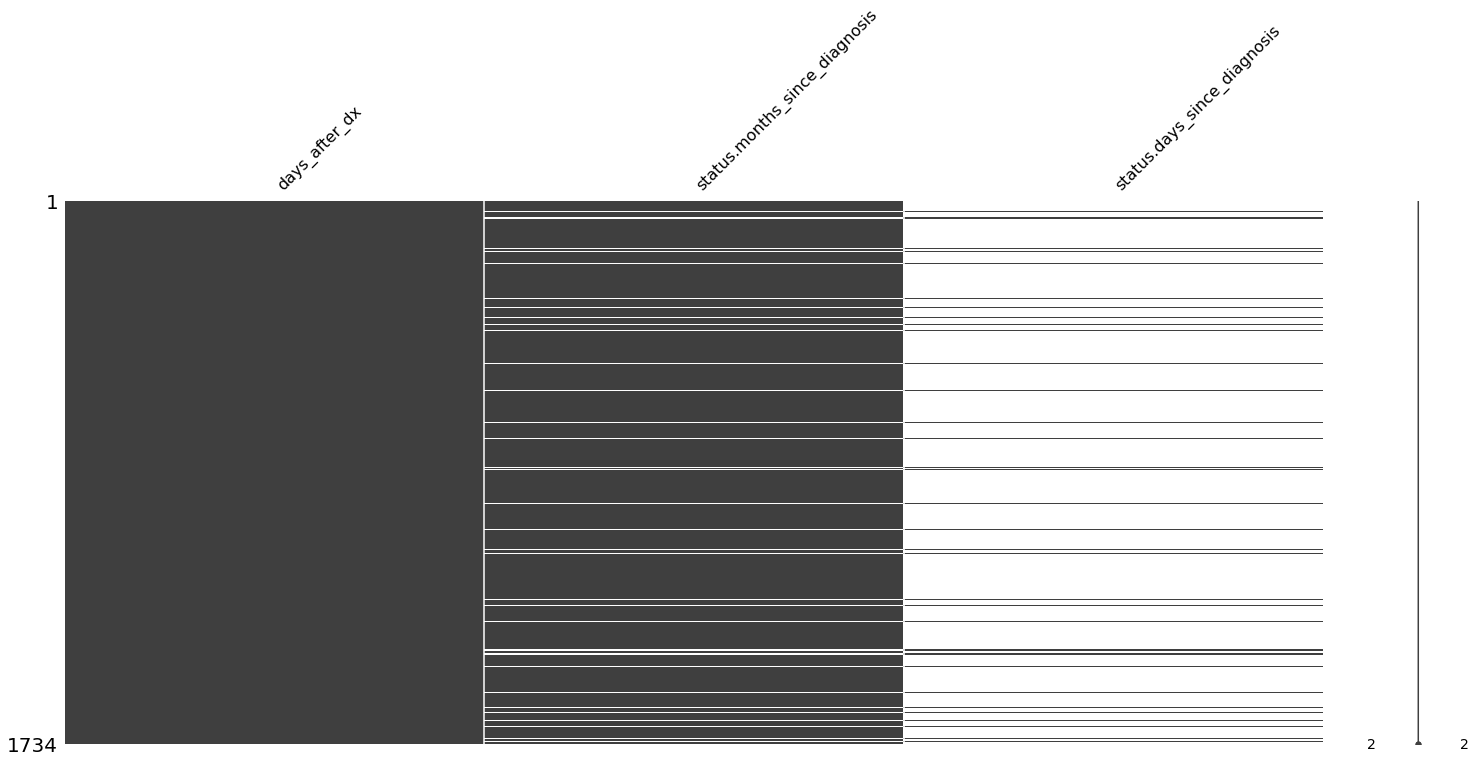

In [13]:
pt_profile['days_after_dx']=np.where(pt_profile['status.days_since_diagnosis'].isnull(), pt_profile['status.months_since_diagnosis']*30, pt_profile['status.days_since_diagnosis'])

df_days = pt_profile[['days_after_dx', 'status.months_since_diagnosis', 'status.days_since_diagnosis']]
df_days[:10]
checking_missing(df_days, df_days.columns)
mbar=msno.matrix(df_days)

In [14]:
pt_profile['status.alcohol_usage'].unique()
pt_profile['alcohol']=pt_profile['status.alcohol_usage'].astype('string').fillna('unknown').apply(lambda x: x.strip().lower())
pt_profile['alcohol'].unique()
pt_profile[['alcohol', 'status.alcohol_usage']][:5]

checking_missing(pt_profile[['alcohol', 'status.alcohol_usage']], pt_profile[['alcohol', 'status.alcohol_usage']].columns)

array([nan, 'LOW', 'NONE', 'MODERATE', 'HIGH'], dtype=object)

array(['unknown', 'low', 'none', 'moderate', 'high'], dtype=object)

,alcohol,status.alcohol_usage
0,unknown,NaN
1,low,LOW
2,unknown,NaN
3,unknown,NaN
4,unknown,NaN



Missing Value Summary
-----------------------------------
alcohol                    0
status.alcohol_usage    1404
dtype: int64


In [15]:
pt_profile['status.exercise_frequency'].unique()
pt_profile['exercise']=pt_profile['status.exercise_frequency'].astype('string').fillna('unknown').apply(lambda x: x.strip().lower())
pt_profile['exercise'].unique()
pt_profile[['exercise', 'status.exercise_frequency']][:5]

checking_missing(pt_profile[['exercise', 'status.exercise_frequency']], pt_profile[['exercise', 'status.exercise_frequency']].columns)

array([nan,  0.,  2.,  1.])

array(['unknown', '0.0', '2.0', '1.0'], dtype=object)

,exercise,status.exercise_frequency
0,unknown,NaN
1,0.0,0.0
2,unknown,NaN
3,unknown,NaN
4,unknown,NaN



Missing Value Summary
-----------------------------------
exercise                        0
status.exercise_frequency    1404
dtype: int64


In [16]:
pt_profile['status.bmi_level'].unique()
pt_profile['bmi']=pt_profile['status.bmi_level'].astype('string').fillna('unknown').apply(lambda x: x.strip().lower())
pt_profile['bmi'].unique()
pt_profile[['bmi', 'status.bmi_level']][:5]

checking_missing(pt_profile[['bmi', 'status.bmi_level']], pt_profile[['bmi', 'status.bmi_level']].columns)

array([nan, 'normal', None, 'overweight', 'obese', 'underweight'],
      dtype=object)

array(['unknown', 'normal', 'overweight', 'obese', 'underweight'],
      dtype=object)

,bmi,status.bmi_level
0,unknown,NaN
1,normal,normal
2,unknown,NaN
3,unknown,NaN
4,unknown,NaN



Missing Value Summary
-----------------------------------
bmi                    0
status.bmi_level    1506
dtype: int64


## 1.5. Creating a cleaned patient profile for feature selection
* Selecting preprocessed columns
* Dropping columns of corhort_id, cohort_qualifier with constant values

In [17]:
pt_profile.columns

Index(['patient_id', 'biomarker_id', 'target_label', 'demographics.gender',
       'demographics.age', 'status.disease_sub_type',
       'status.comorbidity_index', 'status.cohort_qualifier',
       'status.smoking_status', 'status.months_since_diagnosis',
       'demographics.race', 'institution', 'cohort_id',
       'status.days_since_diagnosis', 'status.alcohol_usage',
       'status.exercise_frequency', 'status.bmi_level', 'gender', 'race',
       'smoking', 'age', 'comorbidity', 'days_after_dx', 'alcohol', 'exercise',
       'bmi'],
      dtype='object')

In [18]:
cols_cleaned = ['patient_id', 'biomarker_id', 'target_label', 'gender', 'age', 'race', 'status.disease_sub_type', 'comorbidity', 'smoking', 'days_after_dx', 'institution', 'alcohol', 'bmi', 'exercise']
pt_profile_cleaned = pt_profile[cols_cleaned].rename(columns={"status.disease_sub_type": "disease_sub_type"})

pt_profile_cleaned.head()
pt_profile_cleaned.shape
pt_profile_cleaned.dtypes

,patient_id,biomarker_id,target_label,gender,age,race,disease_sub_type,comorbidity,smoking,days_after_dx,institution,alcohol,bmi,exercise
0,1002df1d3,89c43bb4,0,male,46.0,asian,A,unknown,former,600.0,University Hospital System,unknown,unknown,unknown
1,1010441f,3ae31327,0,male,52.0,black or african american,A,unknown,never,0.0,Montague Hospital,low,normal,0.0
2,101eb6af1,1d8f7bab9,0,female,55.0,missing,B,unknown,never,0.0,"BioLab, Inc.",unknown,unknown,unknown
3,10204394e,129ee8c6c,0,male,69.0,white,A,unknown,never,270.0,University Hospital System,unknown,unknown,unknown
4,1021d329b,1b44145bd,0,male,52.0,asian,A,unknown,former,300.0,University Hospital System,unknown,unknown,unknown


(1734, 14)

patient_id           object
biomarker_id         object
target_label          int64
gender               object
age                 float64
race                 object
disease_sub_type     object
comorbidity          object
smoking              object
days_after_dx       float64
institution          object
alcohol              object
bmi                  object
exercise             object
dtype: object

In [19]:
pt_profile_cleaned_report = pandas_profiling.ProfileReport(pt_profile_cleaned)
pt_profile_cleaned_report.to_file("pt_profile_cleaned.html")

Summarize dataset:   0%|          | 0/27 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## 1.6. Feature selection from patient profile
### 1.6.1. Checking the completeness of data by institution

In [20]:
pt_profile_cleaned.groupby('institution')['patient_id'].count()
pt_profile_cleaned.groupby('institution')['alcohol'].unique()
pt_profile_cleaned.groupby('institution')['bmi'].unique()
pt_profile_cleaned.groupby('institution')['exercise'].unique()
pt_profile_cleaned.groupby('institution')['race'].unique()
pt_profile_cleaned.groupby('institution')['smoking'].unique()

institution
BioLab, Inc.                     696
Goodfellow Research Institute    123
Johnson & Bloom Hospitals         56
Montague Hospital                330
Saint Penelope Medical Center    231
University Hospital System       298
Name: patient_id, dtype: int64

institution
BioLab, Inc.                                       [unknown]
Goodfellow Research Institute                      [unknown]
Johnson & Bloom Hospitals                          [unknown]
Montague Hospital                [low, none, moderate, high]
Saint Penelope Medical Center                      [unknown]
University Hospital System                         [unknown]
Name: alcohol, dtype: object

institution
BioLab, Inc.                                                             [unknown]
Goodfellow Research Institute                                            [unknown]
Johnson & Bloom Hospitals                                                [unknown]
Montague Hospital                [normal, unknown, overweight, obese, underweight]
Saint Penelope Medical Center                                            [unknown]
University Hospital System                                               [unknown]
Name: bmi, dtype: object

institution
BioLab, Inc.                           [unknown]
Goodfellow Research Institute          [unknown]
Johnson & Bloom Hospitals              [unknown]
Montague Hospital                [0.0, 2.0, 1.0]
Saint Penelope Medical Center          [unknown]
University Hospital System             [unknown]
Name: exercise, dtype: object

institution
BioLab, Inc.                     [missing, black or african american, white, as...
Goodfellow Research Institute                                            [missing]
Johnson & Bloom Hospitals        [white, missing, black or african american, as...
Montague Hospital                [black or african american, missing, white, as...
Saint Penelope Medical Center    [white, missing, black or african american, as...
University Hospital System       [asian, white, black or african american, miss...
Name: race, dtype: object

institution
BioLab, Inc.                     [never, current, former, unknown]
Goodfellow Research Institute                            [unknown]
Johnson & Bloom Hospitals        [never, current, former, unknown]
Montague Hospital                [never, current, former, unknown]
Saint Penelope Medical Center    [never, current, former, unknown]
University Hospital System       [former, never, current, unknown]
Name: smoking, dtype: object

count      
positive                      False True 
institution                              
BioLab, Inc.                    541   155
Goodfellow Research Institute    89    34
Johnson & Bloom Hospitals        46    10
Montague Hospital               252    78
Saint Penelope Medical Center   183    48
University Hospital System      242    56

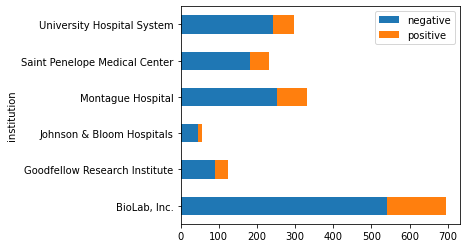

In [21]:
temp = pt_profile_cleaned.assign(positive = lambda x: x.target_label==1.0).groupby(['institution', 'positive']).agg(count=('patient_id','count')).unstack('positive')
temp

ax1 = temp.plot.barh(stacked=True, figsize=(5,4))
ax1.legend(["negative", "positive"]);
plt.show()

### *alcohol, bmi, exercise* are only present in one *institution* which accounts for ~20% of the cohort. We consolidate them into one to improve model performance

### 1.6.2. Selecting features from categorical variables by Chi-Square statistic test

In [22]:
categorical_cols = ['gender', 'race', 'disease_sub_type', 'comorbidity', 'smoking', 'institution', 'bmi', 'alcohol', 'exercise']
target_col = 'target_label'

chi2_check(pt_profile_cleaned, categorical_cols, 'target_label')

target_label    0    1
gender                
female        575  207
male          778  174
Chi2 Statistic for column "gender": 16.33618269969941, p-value: 5.304147212654462e-05
------------------------------------------------------------
target_label                                 0    1
race                                               
american indian or alaska native             9    2
asian                                      130   34
black or african american                  255   67
missing                                    353  105
native hawaiian or other pacific islander   13    5
white                                      593  168
Chi2 Statistic for column "race": 1.0957520591503263, p-value: 0.9544789913668957
------------------------------------------------------------
target_label        0    1
disease_sub_type          
A                 900  256
B                 203   54
C                 131   32
D                  37   14
E                  40   10
F            

,Column,Hypothesis
0,gender,Reject Null Hypothesis
1,race,Fail to Reject Null Hypothesis
2,disease_sub_type,Fail to Reject Null Hypothesis
3,comorbidity,Fail to Reject Null Hypothesis
4,smoking,Reject Null Hypothesis
5,institution,Fail to Reject Null Hypothesis
6,bmi,Fail to Reject Null Hypothesis
7,alcohol,Fail to Reject Null Hypothesis
8,exercise,Reject Null Hypothesis


#### Rejecting Null hypothesis for *gender, exercise, smoking* which are selected as features for modeling

### 1.6.3. Selecting features from continuous variables with visual analysis

<AxesSubplot:xlabel='target_label', ylabel='age'>

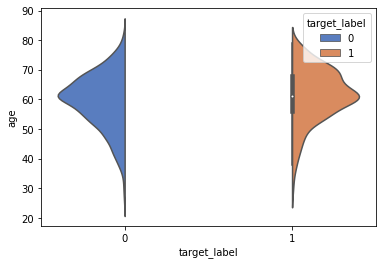

In [23]:
f, ax = plt.subplots()
sns.violinplot(data=pt_profile_cleaned, x='target_label', y='age', hue = 'target_label', palette="muted", split=True)

<AxesSubplot:xlabel='target_label', ylabel='days_after_dx'>

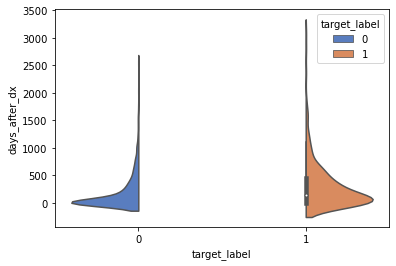

In [24]:
f, ax = plt.subplots()
sns.violinplot(data=pt_profile_cleaned, x='target_label', y='days_after_dx',hue = 'target_label', palette="muted", split=True )

### Figures show different distribution of *days_after_dx* and *age* at *target_label 0, 1*, So they are selected for modeling

### 1.6.4. Creating feature matrix from patient profile

In [25]:
cols = ['age', 'days_after_dx', 'gender', 'smoking', 'exercise', 'patient_id']
pt_profile_feature = pt_profile_cleaned[cols].set_index('patient_id')

pt_profile_feature.shape
pt_profile_feature.head()

(1734, 5)

,age,days_after_dx,gender,smoking,exercise
patient_id,,,,,
1002df1d3,46.0,600.0,male,former,unknown
1010441f,52.0,0.0,male,never,0.0
101eb6af1,55.0,0.0,female,never,unknown
10204394e,69.0,270.0,male,never,unknown
1021d329b,52.0,300.0,male,former,unknown


## 1.7. Biomarkers Table 

### 1.7.1. Right joining biomarkers table with target table to produce biomarker dataset

In [26]:
marker= pd.read_csv('biomarkers.csv').merge(target, how = 'right', on = 'biomarker_id' ).drop('patient_id', axis =1)
marker.head()
marker.shape

,biomarker_id,BM00000,BM00001,BM00002,BM00003,BM00004,BM00005,BM00006,BM00007,BM00008,...,BM15148,BM15149,BM15150,BM15151,BM15152,BM15153,BM15154,BM15155,BM15156,target_label
0,89c43bb4,1,1,1,1,0,0,0,0,1,...,0,0,1,1,0,1,1.0,1,1,0
1,3ae31327,0,1,1,0,0,0,0,0,1,...,0,0,0,1,0,1,1.0,1,1,0
2,1d8f7bab9,1,1,1,1,0,0,0,0,1,...,0,1,0,0,0,1,NaN,1,1,0
3,129ee8c6c,1,1,1,1,0,0,0,0,1,...,0,1,0,0,1,1,1.0,1,1,0
4,1b44145bd,1,1,1,1,0,0,0,0,1,...,0,0,0,0,1,1,1.0,1,1,0


(1734, 15159)

In [27]:
marker.dtypes

biomarker_id     object
BM00000           int64
BM00001           int64
BM00002           int64
BM00003           int64
                 ...   
BM15153           int64
BM15154         float64
BM15155           int64
BM15156           int64
target_label      int64
Length: 15159, dtype: object

### 1.7.2. Imputation of missing values with median

In [28]:
missing_col = marker.columns[marker.isnull().any()]


Missing Value Summary
-----------------------------------
BM01069    696
BM01254    696
BM01671    696
BM02181    696
BM02498    696
BM03527    696
BM05569    696
BM05796    696
BM05946    696
BM05948    696
BM05998    696
BM06148    696
BM06675    696
BM06893    696
BM07163    696
BM07181    696
BM08310    696
BM08420    696
BM08498    696
BM08803    696
BM08828    696
BM09067    696
BM09176    696
BM09302    696
BM09912    696
BM09932    696
BM10396    696
BM11007    696
BM11523    696
BM11929    696
BM12011    696
BM12018    696
BM12119    696
BM12159    696
BM12352    696
BM12379    696
BM12596    696
BM12793    696
BM13623    696
BM13691    696
BM13725    696
BM14027    696
BM14430    696
BM14622    696
BM15091    696
BM15154    696
dtype: int64


(1734, 15159)

,biomarker_id,BM00000,BM00001,BM00002,BM00003,BM00004,BM00005,BM00006,BM00007,BM00008,...,BM15148,BM15149,BM15150,BM15151,BM15152,BM15153,BM15154,BM15155,BM15156,target_label
0,89c43bb4,1,1,1,1,0,0,0,0,1,...,0,0,1,1,0,1,1.0,1,1,0
1,3ae31327,0,1,1,0,0,0,0,0,1,...,0,0,0,1,0,1,1.0,1,1,0
2,1d8f7bab9,1,1,1,1,0,0,0,0,1,...,0,1,0,0,0,1,1.0,1,1,0
3,129ee8c6c,1,1,1,1,0,0,0,0,1,...,0,1,0,0,1,1,1.0,1,1,0
4,1b44145bd,1,1,1,1,0,0,0,0,1,...,0,0,0,0,1,1,1.0,1,1,0


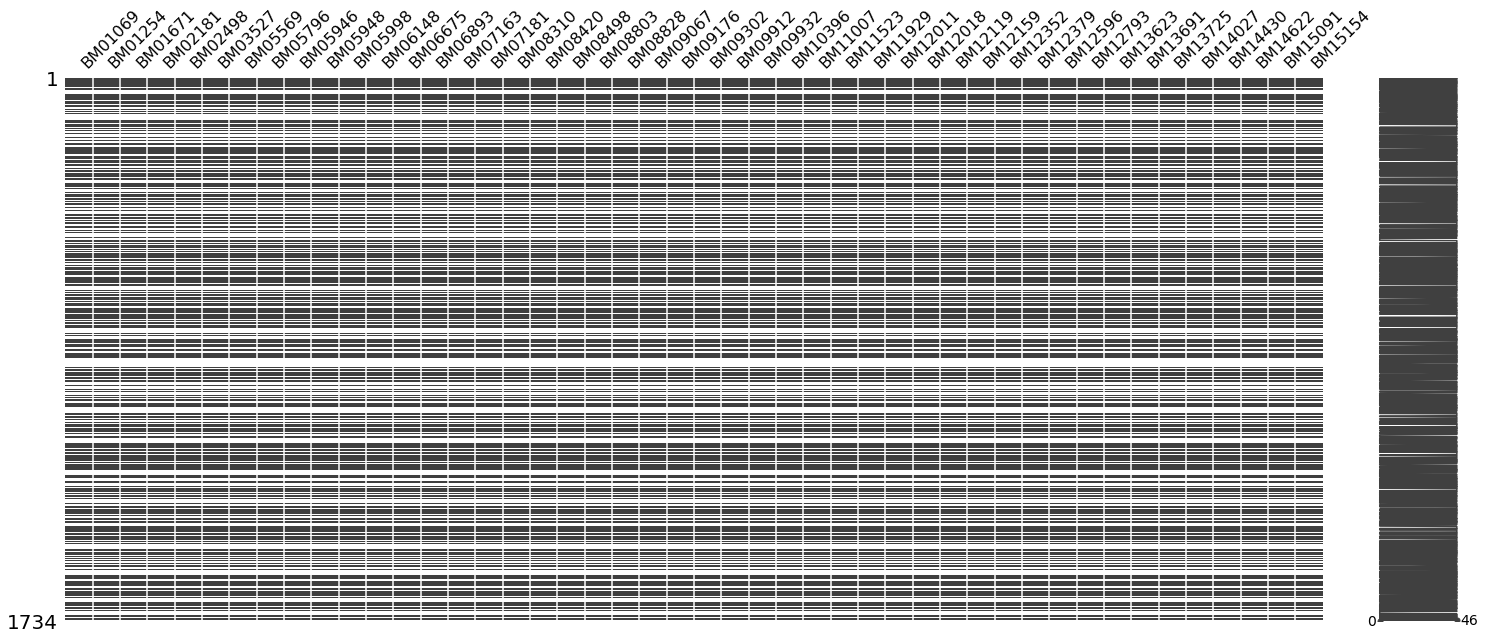

In [29]:
df_missing_cols = marker.loc[:, missing_col]
#df_missing_cols.dtypes
checking_missing(df_missing_cols, df_missing_cols.columns)
#mbar=msno.matrix(marker[missing_col])

marker_cleaned = marker.copy()

for c in missing_col: 
    m = marker[c].median()
    #m=marker[c].mean()+3*marker[c].std()
    marker[c] = marker[c].fillna(m)
    
#marker.fillna(0, inplace = True)
#marker_cleaned = marker.set_index('biomarker_id')
marker.shape
marker.head()

#checking_missing(marker_cleaned[missing_col], marker_cleaned[missing_col].columns)
mbar=msno.matrix(marker_cleaned[missing_col])

### 1.7.3. Selecting biomarker features with Chi-Square Test

In [30]:
%%time

categorical_cols = marker.set_index('biomarker_id').columns

def chi2_check_marker(df, categorical_cols, target_col):
    
    chi2_checked_col = []
    chi2_results = []
    
    for c in categorical_cols:
        temp = pd.crosstab(df[c], df[target_col])
        chi_res = chi2_contingency(temp)
        #print('Chi2 Statistic: {}, p-value: {}\n{}'.format(chi_res[0], chi_res[1], "-"*60))
    
        if  chi_res[1] < 0.05:
            chi2_checked_col.append(c)
            chi2_results.append(chi_res[1])
            
        chi2_output = pd.DataFrame(data = [chi2_checked_col, chi2_results]).T 
        chi2_output.columns = ['bm_passed', 'p_value']
    return chi2_output

chi2_checked_bm = chi2_check_marker(marker, categorical_cols, 'target_label')
chi2_checked_bm.shape
chi2_checked_bm.head()

CPU times: user 9min 10s, sys: 2.38 s, total: 9min 13s
Wall time: 9min 22s


,bm_passed,p_value
0,BM00013,0.02922
1,BM00067,0.01619
2,BM00070,0.037765
3,BM00072,0.010337
4,BM00087,0.049548


In [33]:
feature_bm = chi2_checked_bm['bm_passed'].tolist()
marker_feature = marker.set_index('biomarker_id').loc[:, feature_bm].reset_index()
marker_feature.shape
marker_feature.head()
marker_feature.dtypes

(1734, 611)

,biomarker_id,BM00013,BM00067,BM00070,BM00072,BM00087,BM00112,BM00143,BM00216,BM00229,...,BM14977,BM15017,BM15052,BM15064,BM15121,BM15124,BM15130,BM15137,BM15140,target_label
0,89c43bb4,1,0,1,1,0,0,1,0,1,...,1,1,0,1,0,1,1,1,0,0
1,3ae31327,1,1,1,0,0,0,1,1,1,...,0,1,0,1,1,1,1,1,1,0
2,1d8f7bab9,1,0,1,1,0,0,1,1,1,...,0,1,1,1,1,1,1,1,0,0
3,129ee8c6c,0,1,1,0,0,0,1,0,1,...,0,0,1,1,0,1,1,1,1,0
4,1b44145bd,1,1,0,0,1,0,1,0,1,...,1,1,0,1,0,1,1,1,1,0


biomarker_id    object
BM00013          int64
BM00067          int64
BM00070          int64
BM00072          int64
                 ...  
BM15124          int64
BM15130          int64
BM15137          int64
BM15140          int64
target_label     int64
Length: 611, dtype: object

### Selecting columns as features that reject Null hypothesis 

### There are two columns that appear at both feature columns and imputation columns. Imputation values may have some impact on model performance.

In [39]:
len(set(feature_bm))
len(set(feature_bm)-set(missing_col))

610

608

# 2. Processing Features, Creating Training and Test Dataset for Modeling

In [34]:
pt_profile_feature.head()

,age,days_after_dx,gender,smoking,exercise
patient_id,,,,,
1002df1d3,46.0,600.0,male,former,unknown
1010441f,52.0,0.0,male,never,0.0
101eb6af1,55.0,0.0,female,never,unknown
10204394e,69.0,270.0,male,never,unknown
1021d329b,52.0,300.0,male,former,unknown


## 2.1. Encoding categorical features with one-hot encoding

In [35]:
categorical_cols = ['gender', 'smoking', 'exercise']

pt_profile_ohe = pd.get_dummies(pt_profile_feature.loc[:, categorical_cols])

pt_feature = pt_profile_feature[['age', 'days_after_dx']].join(pt_profile_ohe).reset_index()
pt_feature.head()

,patient_id,age,days_after_dx,gender_female,gender_male,smoking_current,smoking_former,smoking_never,smoking_unknown,exercise_0.0,exercise_1.0,exercise_2.0,exercise_unknown
0,1002df1d3,46.0,600.0,0,1,0,1,0,0,0,0,0,1
1,1010441f,52.0,0.0,0,1,0,0,1,0,1,0,0,0
2,101eb6af1,55.0,0.0,1,0,0,0,1,0,0,0,0,1
3,10204394e,69.0,270.0,0,1,0,0,1,0,0,0,0,1
4,1021d329b,52.0,300.0,0,1,0,1,0,0,0,0,0,1


## 2.2. Creating feature matrix by joining features from patient profile with biomarker

In [36]:
feature_matrix = pt_feature.merge(target, how = 'inner', on='patient_id').drop('target_label', axis =1).merge(marker_feature, on='biomarker_id', how = 'inner').set_index('patient_id')
feature_matrix.head()
feature_matrix.columns
feature_matrix.dtypes

,age,days_after_dx,gender_female,gender_male,smoking_current,smoking_former,smoking_never,smoking_unknown,exercise_0.0,exercise_1.0,...,BM14977,BM15017,BM15052,BM15064,BM15121,BM15124,BM15130,BM15137,BM15140,target_label
patient_id,,,,,,,,,,,,,,,,,,,,,
1002df1d3,46.0,600.0,0,1,0,1,0,0,0,0,...,1,1,0,1,0,1,1,1,0,0
1010441f,52.0,0.0,0,1,0,0,1,0,1,0,...,0,1,0,1,1,1,1,1,1,0
101eb6af1,55.0,0.0,1,0,0,0,1,0,0,0,...,0,1,1,1,1,1,1,1,0,0
10204394e,69.0,270.0,0,1,0,0,1,0,0,0,...,0,0,1,1,0,1,1,1,1,0
1021d329b,52.0,300.0,0,1,0,1,0,0,0,0,...,1,1,0,1,0,1,1,1,1,0


Index(['age', 'days_after_dx', 'gender_female', 'gender_male',
       'smoking_current', 'smoking_former', 'smoking_never', 'smoking_unknown',
       'exercise_0.0', 'exercise_1.0',
       ...
       'BM14977', 'BM15017', 'BM15052', 'BM15064', 'BM15121', 'BM15124',
       'BM15130', 'BM15137', 'BM15140', 'target_label'],
      dtype='object', length=623)

age                float64
days_after_dx      float64
gender_female        uint8
gender_male          uint8
smoking_current      uint8
                    ...   
BM15124              int64
BM15130              int64
BM15137              int64
BM15140              int64
target_label         int64
Length: 623, dtype: object

## 2.3. Spliting traing, test data and standarizing features

In [37]:
X = feature_matrix.drop(axis = 1, columns = ['target_label', 'biomarker_id'])

xcol = list(X.columns)
pt_idx = X.index
col_idx = dict() 
for i in range(len(xcol)):
    col_idx[i] = xcol[i]
print(len(col_idx))

X=X.values
X.shape

Y = feature_matrix['target_label'] 
Y.shape

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 21)

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

621


(1734, 621)

(1734,)

In [38]:
len(pt_feature.columns)-1

12

## 2.4. Dealing with imbalanced data

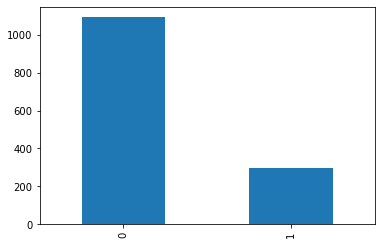

In [40]:
# The ratio of positive target vs. negative (0) is ~ 20%
pd.Series(Y_train).value_counts().plot.bar();

### The training data is skewed towards negative(0). It can results in poor model performance for the positive(1) class. 
### We used SMOTE technique to produce balanced dataset for training

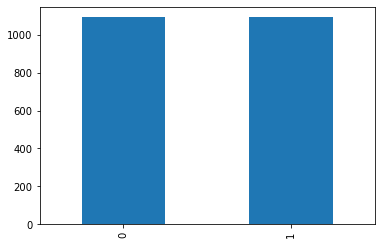

In [41]:
oversample = BorderlineSMOTE(random_state=10, kind="borderline-2")
train_x, train_y = oversample.fit_resample(X_train, Y_train.ravel())
pd.Series(train_y).value_counts().plot.bar();

## 2.5. Dimensionality reduction of biomarker features to prevent model overfitting 

1. Using PCA or t-SNE for dimensionality reducation
2. Concatenating reduced biomarker features with patient profile features to create a new feature matrix for training 

In [42]:
def pca_marker(X, l, n=2):
    
    x = X[:, l:]

    pca = PCA(n_components=n)
    #pca = KernelPCA(n_components=5, kernel='rbf', gamma=15, random_state=42)
    dr = pca.fit_transform(x)
    print(pca.explained_variance_ratio_.sum())
    
    new_x = np.concatenate((X[:, :l], dr), axis=1)
    
    return new_x


def tsne_marker(X, l, m=2, n=2):
    
    x = X[:, l:]

    pca = PCA(n_components=m)
    tsne = TSNE(n_components=n)#, perplexity=20, n_iter=1000, learning_rate=200)
    tsne_after_pca = Pipeline([('pca', pca), ('tsne', tsne)])
    dr = tsne_after_pca.fit_transform(x)
   
    new_x = np.concatenate((X[:, :l], dr), axis=1)
    
    return new_x



In [43]:
l = len(pt_feature.columns)-1
n_pca = 20
n_tsne = 2

x_train = tsne_marker(train_x, l, n_pca, n_tsne)
x_train.shape

x_test = tsne_marker(X_test, l, n_pca, n_tsne)
x_test.shape

(2182, 14)

(347, 14)

# 3. Model Training
## 3.1. dummy classifier

In [44]:
dummy_classprop = DummyClassifier(strategy='stratified').fit(x_train, train_y)

y_classprop_predicted = dummy_classprop.predict(x_test)

dummy_confusion = confusion_matrix(Y_test, y_classprop_predicted)
print('Most frequent class (dummy classifier)\n', dummy_confusion)
print(classification_report(Y_test, y_classprop_predicted))

Most frequent class (dummy classifier)
 [[128 134]
 [ 52  33]]
              precision    recall  f1-score   support

           0       0.71      0.49      0.58       262
           1       0.20      0.39      0.26        85

    accuracy                           0.46       347
   macro avg       0.45      0.44      0.42       347
weighted avg       0.59      0.46      0.50       347



## 3.2. Logistic regression, Random forest, SVM classifier 

In [45]:
LR = LogisticRegressionCV() 
LR.fit(x_train, train_y)
prob = LR.predict_proba(x_test)
bino = LR.predict(x_test)

print(classification_report(Y_test, bino))
roc_auc_score(Y_test, prob[:,1])


LogisticRegressionCV()

              precision    recall  f1-score   support

           0       0.82      0.66      0.73       262
           1       0.34      0.54      0.42        85

    accuracy                           0.63       347
   macro avg       0.58      0.60      0.58       347
weighted avg       0.70      0.63      0.66       347



0.6276605298607993

In [46]:
model = SVC(kernel='linear')
model.fit(x_train, train_y)
prediction = model.predict(x_test)

print(classification_report(Y_test, prediction))
print('AUC: ', roc_auc_score(Y_test, prediction))

SVC(kernel='linear')

              precision    recall  f1-score   support

           0       0.81      0.75      0.78       262
           1       0.37      0.45      0.40        85

    accuracy                           0.68       347
   macro avg       0.59      0.60      0.59       347
weighted avg       0.70      0.68      0.69       347

AUC:  0.5994836102379882


In [47]:
RFC = RandomForestClassifier(oob_score = True).fit(x_train, train_y)
prob_out = RFC.predict_proba(x_test)
class_out = RFC.predict(x_test)

print(classification_report(Y_test, class_out))
print('AUC: ', roc_auc_score(Y_test, prob_out[:,1]))

              precision    recall  f1-score   support

           0       0.79      0.63      0.70       262
           1       0.30      0.49      0.37        85

    accuracy                           0.59       347
   macro avg       0.55      0.56      0.54       347
weighted avg       0.67      0.59      0.62       347

AUC:  0.5993488998652896


### We choose logistic regression since it produce the highes recall. 

## 3.3. Model Evaluation
### 3.3.1. Ranking of feature importance  

In [48]:
pd.Series(LR.coef_[0], index = xcol[:l+n_tsne]).nlargest(l+n_tsne)

age                 0.263403
days_after_dx       0.239344
smoking_current     0.158600
gender_female       0.116978
exercise_0.0        0.036913
BM00013             0.033784
smoking_unknown    -0.003113
exercise_unknown   -0.011840
BM00067            -0.017517
exercise_2.0       -0.026954
exercise_1.0       -0.034955
smoking_former     -0.035458
smoking_never      -0.108129
gender_male        -0.116978
dtype: float64

### The ranking of feature importance from model output shows:
1. Age, days after diagnosis, current smoking status show positive association with positive class. 
2. Female shows high prevalence than male
3. The impact of biomarker on target is different. One shows negative association and the other shows minor positive association. BM0013, BM0067 are not original biomarker columns but the proxy names for biomarker features after dimentionality reduction. 
4. Association of exercise needs further investigation since it is only present in one institutuion that has only ~20% of the cohort

### 3.3.2. Hyperparameters tuning with Gridsearch to get optimal performance

In [78]:
LR2 = LogisticRegressionCV()

params_grid = {"solver":['saga', 'liblinear'], "penalty":["l1", "l2"], "Cs":list(range(1,11,3)) }

kfold = StratifiedKFold(n_splits=10, shuffle = True, random_state=7)

gridsearch = GridSearchCV(LR2, param_grid=params_grid, scoring = 'neg_log_loss', n_jobs = -1, cv = kfold)

gridresult = gridsearch.fit(x_train, train_y)

print(gridresult.best_score_, gridsearch.best_params_)

-0.5710797901038542 {'Cs': 4, 'penalty': 'l1', 'solver': 'liblinear'}


In [79]:
LR3 = LogisticRegressionCV(solver=gridsearch.best_params_['solver'], penalty=gridsearch.best_params_['penalty'], Cs = gridsearch.best_params_['Cs'])

### 3.3.3. Cross-validtion of model using optimal hyperparameters
### Average performance metric

In [80]:
count = 0
recall_list = []
precision_list = []
f1_list = []
roc_auc_list = []

while count < 10:
    
    kfold = StratifiedKFold(n_splits=10, shuffle = True, random_state=5) 
    s_recall = cross_val_score(LR3, x_train, train_y, cv= kfold,scoring='recall')
    s_roc_auc = cross_val_score(LR3, x_train, train_y, cv= kfold,scoring='roc_auc')
    s_precision =cross_val_score(LR3, x_train, train_y, cv= kfold,scoring='precision')
    s_f1 = cross_val_score(LR3, x_train, train_y, cv= kfold, scoring='f1')
    
    recall_list.append(np.mean(s_recall))
    precision_list.append(np.mean(s_precision))
    f1_list.append(np.mean(s_f1))
    roc_auc_list.append(np.mean(s_roc_auc))
    
    count += 1
    
print("recall: {:.3f}".format(np.mean(recall_list)))
print("precision: {:.3f}".format(np.mean(precision_list)))
print("f1: {:.3f}".format(np.mean(f1_list)))
print("ROC_AUC: {:.3f}".format(np.mean(roc_auc_list)))

recall: 0.704
precision: 0.725
f1: 0.714
ROC_AUC: 0.775


### Validation with test data

In [82]:
LR3.fit(x_train, train_y)

prediction = LR3.predict(x_test)
bino = LR3.predict(x_test)
prob = LR3.predict_proba(x_test)

confusion_matrix_1(bino, Y_test)

LogisticRegressionCV(Cs=4, penalty='l1', solver='liblinear')

              precision    recall  f1-score   support

           0       0.82      0.63      0.71       262
           1       0.33      0.58      0.42        85

    accuracy                           0.61       347
   macro avg       0.58      0.60      0.57       347
weighted avg       0.70      0.61      0.64       347



,actual_positive,actual_negative
predict_positive,49,98
predict_negative,36,164


### Model generalizability

In [85]:
kfold = StratifiedKFold(n_splits=10, shuffle = True)

X_new = np.concatenate((x_train, x_test), axis = 0)
Y_new = np.concatenate((train_y, Y_test))

LC = learning_curve(estimator = LR3, X = X_new, y = Y_new, cv = kfold, train_sizes = np.linspace(0.10, 1.00, 10))

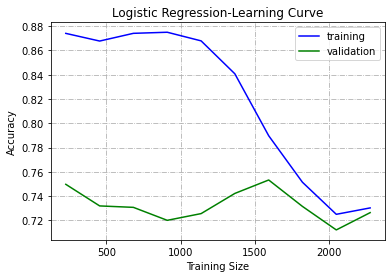

In [86]:
plt.figure();
plt.title("Logistic Regression-Learning Curve");
plt.plot(LC[0],np.nanmean(LC[1],axis = 1),c = 'blue');
plt.plot(LC[0],np.nanmean(LC[2],axis = 1), c = 'green');
plt.xlabel("Training Size");
plt.legend(['training', 'validation']);
plt.ylabel("Accuracy");
plt.grid(linestyle='-.');
plt.show();

# Summary and Further work 
As shown above, the training accuracy and validation accuracy coverge with increasing training size, indicating overfitting is not a issue. However, the accuracy reached a plataeu at 0.73 and the recall/sensitivity of the test data is 0.58. Since sensitivity is an important metric for disease prediction, the performance of the model is far from satisfactory. Further work to improve the performance  includes: 
* Feature selection and engineering
* Diffferent model such as XGBoost 
* Different imputation and imbalanced sampling techniques